In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
import os

In [1]:
# Used https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/
def positionalEncoding(seq_len, d, n=10000):
    p = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            p[k, 2*i] = np.sin(k/denominator)
            p[k, 2*i+1] = np.cos(k/denominator)
    return p

In [21]:
# Generate EG3D Images
from camera_utils import LookAtPoseSampler, FOV_to_intrinsics
device = 'cuda'
cam2world_pose = LookAtPoseSampler.sample(3.14/2, 3.14/2, torch.tensor([0, 0, 0.2], device=device), radius=2.7, device=device)
intrinsics = FOV_to_intrinsics(18, device=device)

with open('eg3d_model/ffhqrebalanced512-128.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
c = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1) # camera parameters
# z = torch.randn([1, G.z_dim]).cuda()    # latent codes
z = torch.tensor(znprecon).view(-1, 512).cuda()

# img = G(z, c)['image']                           # NCHW, float32, dynamic range [-1, +1], no truncation

cam_pivot = torch.tensor(G.rendering_kwargs.get('avg_camera_pivot', [0, 0, 0]), device=device)
cam_radius = G.rendering_kwargs.get('avg_camera_radius', 2.7)
cam2world_pose = LookAtPoseSampler.sample(np.pi/2, np.pi/2, cam_pivot, radius=cam_radius, device=device)
conditioning_cam2world_pose = LookAtPoseSampler.sample(np.pi/2, np.pi/2, cam_pivot, radius=cam_radius, device=device)
camera_params = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)
conditioning_params = torch.cat([conditioning_cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)
w = G.mapping(z, conditioning_params, truncation_psi=0.5, truncation_cutoff=8)
img = G.synthesis(w, camera_params)['image']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


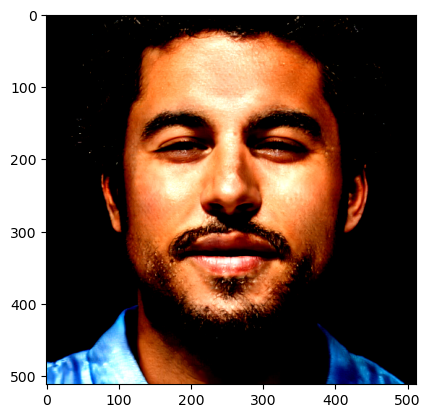

In [22]:
cpu_img = img.cpu().numpy()[0].transpose(1, 2, 0) + 0.3
plt.imshow(cpu_img)
plt.show()

/tmp/ipykernel_22534/3739348662.py:9: RuntimeWarning: invalid value encountered in divide
  znprecon = np.nanmean(product/A, axis=0)


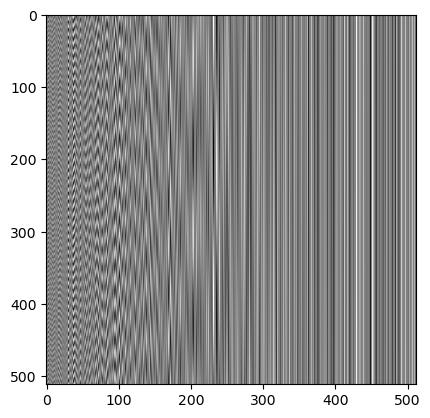

In [23]:
size = G.z_dim
num = 10

A = positionalEncoding(size, size)

znp = z[0].cpu().numpy()
product = A * znp

znprecon = np.nanmean(product/A, axis=0)

plt.imshow(product, cmap='gray', interpolation='none')
plt.show()
